In [13]:
%load_ext autoreload
import os,sys
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import progressbar
from datetime import datetime
sys.path.append("../")

print(sys.path)

%autoreload 2
from src.pySRM.pysrm.segment import IMZMLExtract, SpectraRegion, ProteinWeights, CombinedSpectra
from collections import Counter, defaultdict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/mjoppich/.local/lib/python3.6/site-packages', '/home/mjoppich/.local/lib/python3.6/site-packages/mpld3-0.3.1.dev1-py3.6.egg', '/home/mjoppich/.local/lib/python3.6/site-packages/opennre-0.1-py3.6.egg', '/usr/local/lib/python3.6/dist-packages', '/usr/local/lib/python3.6/dist-packages/tf_unet-0.1.1-py3.6.egg', '/mnt/d/PythonCGI/jupyter_micropython_kernel', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/home/mjoppich/.ipython', '../', '../', '../']


In [1]:
! ls /mnt/d/dev/data/msi/AL1_1

200213_AL1_1.ibd    200213_AL1_1.imzML.regions	200213_AL1_1_spotlist.txt
200213_AL1_1.imzML  200213_AL1_1_Plot.jpg


In [3]:
imze = IMZMLExtract("/mnt/d/dev/data/msi/AL1_1/200213_AL1_1.imzML")

Opening regions file for /mnt/d/dev/data/msi/AL1_1/200213_AL1_1.imzML


0 ((4449, 4505, 938, 1002), 3705)
1 ((4490, 4532, 1365, 1415), 2180)
2 ((3542, 3644, 1195, 1262), 7004)
3 ((2409, 2502, 1572, 1633), 5828)
4 ((4559, 4646, 1158, 1250), 8158)
5 ((2317, 2372, 1400, 1490), 5096)
6 ((2317, 2387, 1648, 1702), 3905)


<Figure size 1440x576 with 0 Axes>

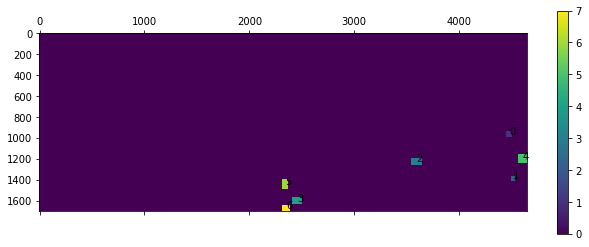

{0: ((4449, 4505, 938, 1002), 3705),
 1: ((4490, 4532, 1365, 1415), 2180),
 2: ((3542, 3644, 1195, 1262), 7004),
 3: ((2409, 2502, 1572, 1633), 5828),
 4: ((4559, 4646, 1158, 1250), 8158),
 5: ((2317, 2372, 1400, 1490), 5096),
 6: ((2317, 2387, 1648, 1702), 3905)}

In [14]:
plt.figure(figsize=(20, 8))
imze.list_regions()

In [56]:
avg_region_spectrum = imze.get_avg_region_spectrum(2)

Found region 2 with shape (103, 68, 38800)
I0708 00:02:23.469273 140153823102784 segment.py:2814] Found region 2 with shape (103, 68, 38800)


In [5]:
maxShift = 20

In [6]:
#spectra_orig_nobg, spectra_orig_nobg_masses = imze.remove_background_spec_aligned(spectra_orig,avg_region_spectrum, imze.mzValues, 20)
#sh_sporig, sh_masses_sporig = imze.shift_region_array(spectra_orig_nobg, spectra_orig_nobg_masses, maxShift)

In [ ]:
#spectra_intra = imze.normalize_region_array(sh_sporig, normalize="intra_median")
#sh_sporig_norm = imze.normalize_region_array(spectra_intra, normalize="inter_median")

In [15]:
spectra_orig = imze.get_region_array(3, makeNullLine=True)
#sh_sporig_bg, sh_masses_sporig_bg = imze.shift_region_array(spectra_orig, imze.mzValues, maxShift)

Found region 3 with shape (94, 62, 38800)
I0707 21:56:03.955795 140153823102784 segment.py:2784] Found region 3 with shape (94, 62, 38800)


In [16]:
spectra_intra = imze.normalize_region_array(spectra_orig, normalize="intra_median")

In [17]:
sh_sporig_bg = None
spectra_orig = None

sh_sporig_bg = imze.normalize_region_array(spectra_intra, normalize="inter_median")

I0707 21:56:21.368040 140153823102784 segment.py:2498] Collecting fold changes
Got a total of 226126400 fold changes
I0707 21:59:29.775381 140153823102784 segment.py:2509] Got a total of 226126400 fold changes
Median elements [113063200]
I0707 21:59:30.635976 140153823102784 segment.py:2518] Median elements [113063200]
Median elements
I0707 21:59:31.212101 140153823102784 segment.py:2531] Median elements
Global Median 0.96625
I0707 21:59:31.214073 140153823102784 segment.py:2536] Global Median 0.96625


In [65]:
def plot_coords(arr, coords, valRange, xvals):
    plt.figure(figsize=(20, 6))
        
    for x in coords:
        plt.plot(xvals[valRange], arr[x[0], x[1]][valRange], label=str(x))
    plt.legend()

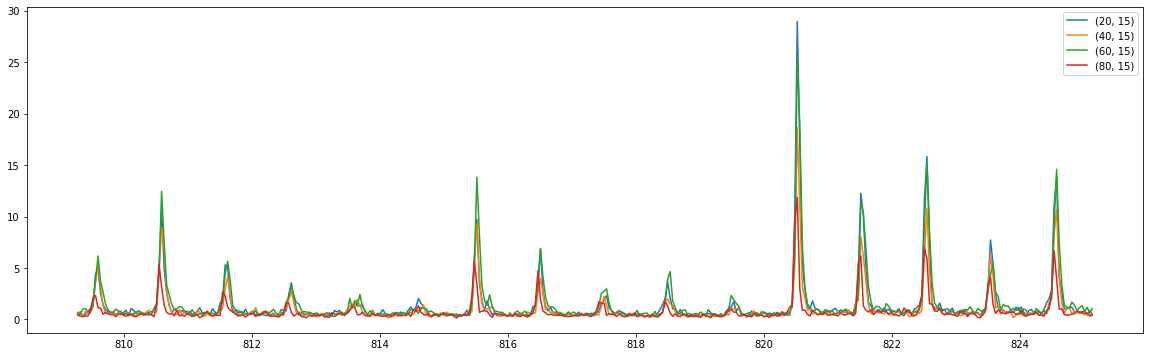

In [79]:
plot_coords(sh_sporig_bg, [(20,15), (40,15), (60,15), (80,15)], range(8800,9200), imze.mzValues)

In [ ]:
imze.list_highest_peaks(sh_sporig_bg, counter=True)

In [14]:
specbg_sh = SpectraRegion(sh_sporig_bg, imze.mzValues)

In [ ]:
specbg_sh.calculate_similarity(mode="spectra")

In [13]:
specbg_sh.segment(method="WARD", number_of_regions=15)

2020-07-06 20:21:27,744  SpectraRegion  INFO: Calculating clusters
I0706 20:21:27.744817 140713004238656 segment.py:1038] Calculating clusters
2020-07-06 20:21:29,779  SpectraRegion  INFO: Calculating clusters done
I0706 20:21:29.779917 140713004238656 segment.py:1053] Calculating clusters done
2020-07-06 20:21:29,829  SpectraRegion  INFO: Calculating clusters saved
I0706 20:21:29.829128 140713004238656 segment.py:1071] Calculating clusters saved


array([[14,  5, 11, ...,  9, 11,  2],
       [11, 14, 11, ...,  1,  1,  1],
       [ 5, 14, 14, ...,  1,  1,  1],
       ...,
       [12, 12,  4, ...,  4, 11, 12],
       [ 9,  9, 12, ...,  4,  4,  4],
       [11,  9, 12, ...,  4,  4, 12]], dtype=int16)

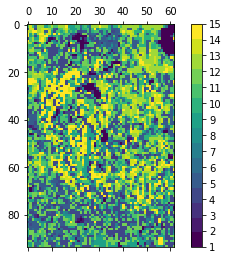

In [14]:
specbg_sh.plot_segments()

In [ ]:
sh_masses_sporig_bg.shape

In [ ]:
sh_sporig_bg.shape

In [9]:
def calc_band_pixels(spre):
    
    band_pixels = set()
    
    xmax = spre.shape[0]
    ymax = spre.shape[1]
    
    p2 = np.array([xmax, ymax])
    p1 = np.array([0,0])
    
    for i in range(spre.shape[0]):
        for j in range(spre.shape[1]):
            
            p3 = np.array([i,j])
            d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
            
            if d < 2:
                band_pixels.add((i,j))
                
    return band_pixels
    

In [18]:
spectra = sh_sporig_bg
spectra.shape

(94, 62, 38800)

In [19]:
global_fcs = Counter()
scalingFactor = 1


fcMasses = set()
fcMassesCounter = Counter()
masses2fcs = defaultdict(list)

spectra_band_pixels = calc_band_pixels(spectra)

stdMul = 8

bar = progressbar.ProgressBar(widgets=[
        progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
    ])

for k in bar(range(spectra.shape[0])):
    for l in range(spectra.shape[1]):
        

        for i in range(spectra.shape[0]):
            for j in range(spectra.shape[1]):
                
                if (k,l) == (i,j):
                    continue
                
                    
                if not (k,l) in spectra_band_pixels or not (i,j) in spectra_band_pixels:
                    continue

                fcs = np.log( (spectra[i][j]+(1.0/scalingFactor)) / (spectra[k][l] +(1.0/scalingFactor)) )
                
                meanFCs = np.mean(fcs)
                stdFCs = np.std(fcs)
                
                maxFC = meanFCs + stdMul*stdFCs
                minFC = meanFCs - stdMul*stdFCs
                                    
                if len(fcMassesCounter) % 1000 == 0:
                    print("Masses: ", len(fcMassesCounter))
                
                for i, x in enumerate(fcs):
                    if x < minFC or x > maxFC:
                        
                        fcMass = imze.mzValues[i]
                        
                        masses2fcs[fcMass].append(x)
                        fcMassesCounter[fcMass] += 1



                

Masses:  0


|##########################################################| 100% Time: 0:10:17


In [20]:
mat = spec_subset.mass_heatmap([x[0] for x in fcMassesCounter.most_common(10)])

NameError: name 'spec_subset' is not defined

In [152]:
mat

array([[5326.58762173, 5167.66817661, 6833.09299955, ..., 5615.70948737,
        3913.21431955,  468.95192943],
       [4140.67476945, 4465.18363546, 4076.88668161, ...,  405.34670098,
         306.46165439,  225.11615917],
       [2254.62717051, 4590.50757754, 3862.53469891, ...,  226.95460864,
         224.7715796 ,  230.91791985],
       ...,
       [5108.30428634, 3680.71989384, 4543.64740161, ..., 7161.10759195,
        6168.231464  , 4375.9311858 ],
       [3898.19281505, 4434.26533755, 3424.75123834, ..., 3521.37822073,
        4233.98266878, 4728.99301485],
       [2626.78000028, 3988.02493027, 3001.81835669, ..., 4578.11039944,
        4082.21296649, 3357.96968488]])

In [157]:
np.save("mat_10_save.npy", mat)

2020-07-07 00:00:46,624  SpectraRegion  INFO: Processing Mass 611.4480565657278 with best existing mass 611.4480565657278
I0707 00:00:46.624526 140209083385664 segment.py:777] Processing Mass 611.4480565657278 with best existing mass 611.4480565657278


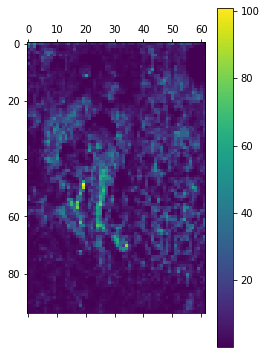

2020-07-07 00:00:46,934  SpectraRegion  INFO: Processing Mass 611.4083546782623 with best existing mass 611.4083546782623
I0707 00:00:46.934003 140209083385664 segment.py:777] Processing Mass 611.4083546782623 with best existing mass 611.4083546782623


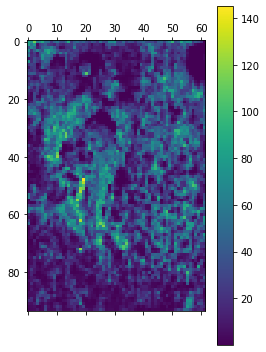

2020-07-07 00:00:47,253  SpectraRegion  INFO: Processing Mass 655.4774497649986 with best existing mass 655.4774497649986
I0707 00:00:47.253456 140209083385664 segment.py:777] Processing Mass 655.4774497649986 with best existing mass 655.4774497649986


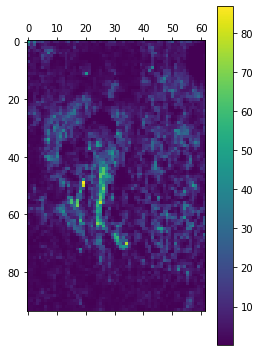

2020-07-07 00:00:47,500  SpectraRegion  INFO: Processing Mass 567.3789614789916 with best existing mass 567.3789614789916
I0707 00:00:47.500478 140209083385664 segment.py:777] Processing Mass 567.3789614789916 with best existing mass 567.3789614789916


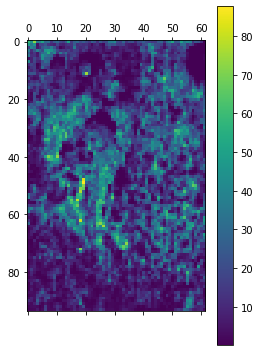

2020-07-07 00:00:47,749  SpectraRegion  INFO: Processing Mass 743.4965342760745 with best existing mass 743.4965342760745
I0707 00:00:47.749208 140209083385664 segment.py:777] Processing Mass 743.4965342760745 with best existing mass 743.4965342760745


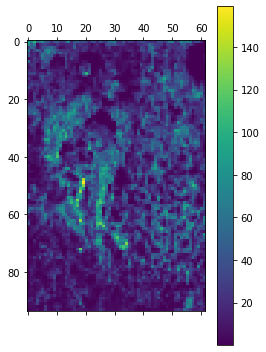

2020-07-07 00:00:48,002  SpectraRegion  INFO: Processing Mass 699.4671410768037 with best existing mass 699.4671410768037
I0707 00:00:48.002355 140209083385664 segment.py:777] Processing Mass 699.4671410768037 with best existing mass 699.4671410768037


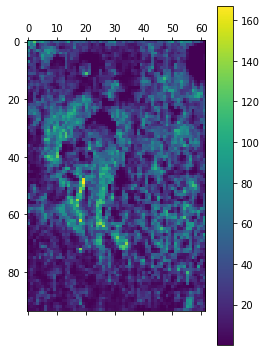

2020-07-07 00:00:48,368  SpectraRegion  INFO: Processing Mass 787.5259274753452 with best existing mass 787.5259274753452
I0707 00:00:48.368219 140209083385664 segment.py:777] Processing Mass 787.5259274753452 with best existing mass 787.5259274753452


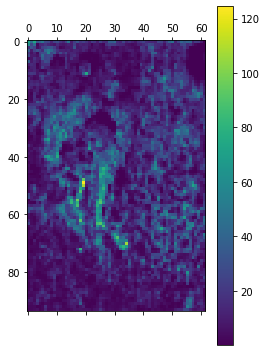

2020-07-07 00:00:48,624  SpectraRegion  INFO: Processing Mass 699.5068429642693 with best existing mass 699.5068429642693
I0707 00:00:48.624607 140209083385664 segment.py:777] Processing Mass 699.5068429642693 with best existing mass 699.5068429642693


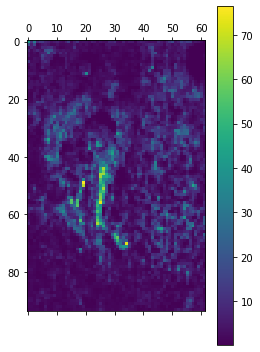

2020-07-07 00:00:48,878  SpectraRegion  INFO: Processing Mass 567.4186633664572 with best existing mass 567.4186633664572
I0707 00:00:48.878407 140209083385664 segment.py:777] Processing Mass 567.4186633664572 with best existing mass 567.4186633664572


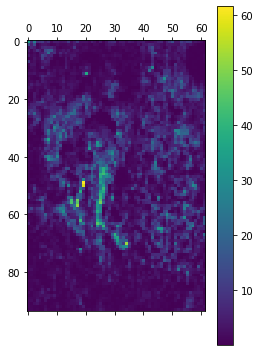

2020-07-07 00:00:49,200  SpectraRegion  INFO: Processing Mass 655.4377478775331 with best existing mass 655.4774497649986
I0707 00:00:49.200885 140209083385664 segment.py:777] Processing Mass 655.4377478775331 with best existing mass 655.4774497649986


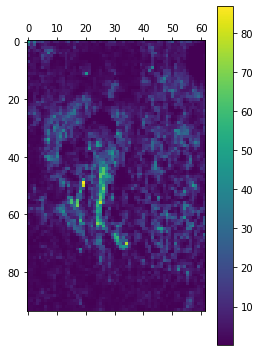

2020-07-07 00:00:49,479  SpectraRegion  INFO: Processing Mass 700.459688263442 with best existing mass 699.5068429642693
I0707 00:00:49.479655 140209083385664 segment.py:777] Processing Mass 700.459688263442 with best existing mass 699.5068429642693


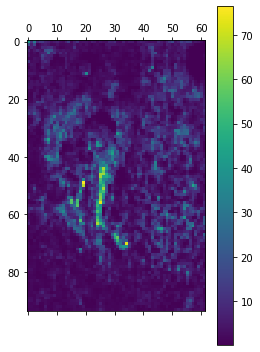

2020-07-07 00:00:49,745  SpectraRegion  INFO: Processing Mass 743.53623616354 with best existing mass 743.53623616354
I0707 00:00:49.745805 140209083385664 segment.py:777] Processing Mass 743.53623616354 with best existing mass 743.53623616354


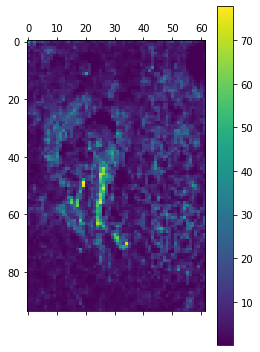

2020-07-07 00:00:50,027  SpectraRegion  INFO: Processing Mass 758.6229534004407 with best existing mass 743.53623616354
I0707 00:00:50.027329 140209083385664 segment.py:777] Processing Mass 758.6229534004407 with best existing mass 743.53623616354


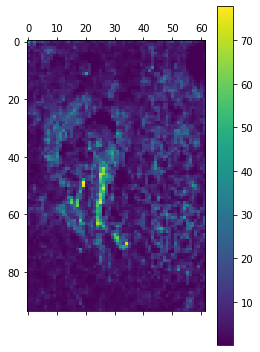

2020-07-07 00:00:50,306  SpectraRegion  INFO: Processing Mass 831.5553206746158 with best existing mass 787.5259274753452
I0707 00:00:50.306170 140209083385664 segment.py:777] Processing Mass 831.5553206746158 with best existing mass 787.5259274753452


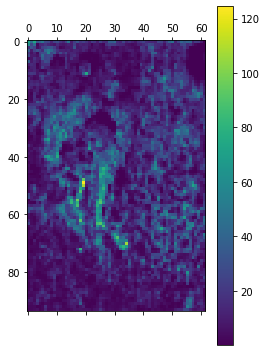

2020-07-07 00:00:50,557  SpectraRegion  INFO: Processing Mass 656.4302950641712 with best existing mass 655.4774497649986
I0707 00:00:50.557513 140209083385664 segment.py:777] Processing Mass 656.4302950641712 with best existing mass 655.4774497649986


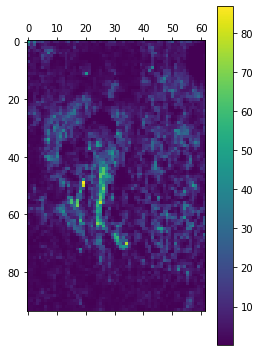

In [102]:
for x,y in fcMassesCounter.most_common(15):
    spec_subset.mass_heatmap(x)

In [21]:
len(fcMassesCounter)

719

In [22]:
mcmasses = [x[0] for x in fcMassesCounter.most_common(10000)]
len(mcmasses)

719

In [23]:
fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in mcmasses])

In [24]:
sub_peaks = spectra[:,:,fcIndices]
sub_masses = imze.mzValues[fcIndices]

In [75]:
sub_peaks_len = sub_peaks / sub_peaks.sum(2)

ValueError: operands could not be broadcast together with shapes (94,62,719) (94,62) 

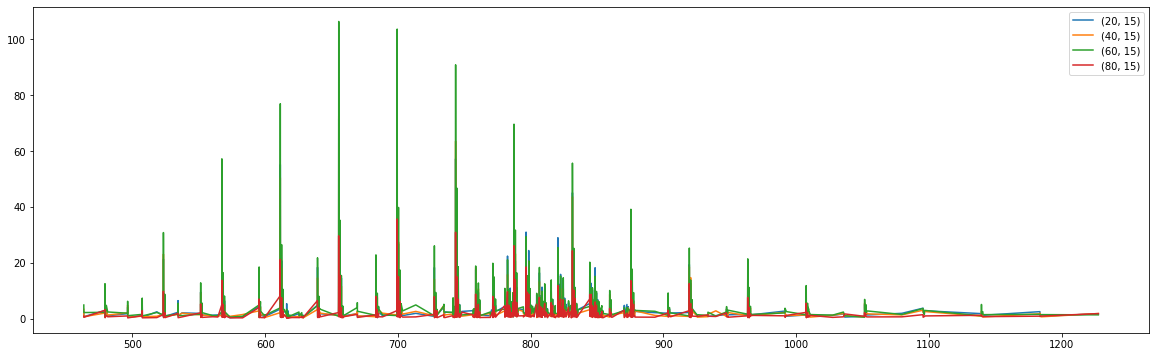

In [71]:
plot_coords(sub_peaks, [(20,15), (40,15), (60,15), (80,15)], range(0,719), sub_masses)

In [66]:
sub_masses

array([ 463.32031443,  463.36001632,  479.24077131,  479.28047319,
        479.32017508,  479.35987697,  479.39957886,  480.31272227,
        481.30526945,  496.31258292,  496.3522848 ,  496.39198669,
        496.43168858,  507.27030386,  507.31000574,  507.34970763,
        507.38940952,  507.42911141,  518.34713046,  523.23046262,
        523.2701645 ,  523.30986639,  523.34956828,  523.38927017,
        523.42897205,  523.46867394,  524.26271169,  524.30241358,
        524.34211547,  524.38181735,  524.42151924,  524.46122113,
        534.26758733,  534.30728922,  534.34699111,  534.386693  ,
        537.32463267,  551.29969706,  551.33939894,  551.37910083,
        551.41880272,  551.45850461,  552.33194613,  552.37164802,
        552.4113499 ,  560.3517274 ,  564.32191614,  567.25985582,
        567.2995577 ,  567.33925959,  567.37896148,  567.41866337,
        567.45836525,  567.49806714,  568.252403  ,  568.29210489,
        568.33180678,  568.37150867,  568.41121055,  568.45091

In [19]:
def calc_similarity( mat ):

    #mat = np.array(sub_peaks, copy=True)

    bar = progressbar.ProgressBar(widgets=[
            progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
        ])    
    elems = mat.shape[0]*mat.shape[1]

    result = np.zeros((elems, elems))

    meanMat = np.zeros((elems, elems))
    stdMat = np.zeros((elems, elems))

    print("Calculating cosine similarity Start", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    for i in bar(range(0, mat.shape[0])):
        for j in range(0, mat.shape[1]):
            idxI = i*mat.shape[1] + j
            matIJ = mat[i,j,:]

            for k in range(0, mat.shape[0]):
                for l in range(0, mat.shape[1]):
                    idxJ = k*mat.shape[1] + l
                    matKL = mat[k,l,:]

                    if idxJ == idxI:
                        result[idxI, idxJ] = len(matIJ)
                        continue

                    if idxJ < idxJ:
                        continue

                    fcs = np.log((matIJ+0.1) / (matKL+0.1))
                    #fcs = sorted(fcs)

                    meanFCs = np.mean(fcs)
                    stdFCs = np.std(fcs)

                    meanMat[idxI, idxJ] = meanFCs
                    stdMat[idxI, idxJ] = stdFCs

                    maxFC = meanFCs + 2*stdFCs
                    minFC = meanFCs - 2*stdFCs
                    
                    #print(min(fcs), max(fcs), minFC, maxFC)

                    kfcs = fcs[fcs <= maxFC]
                    kfcs = kfcs[minFC <= kfcs]

                    sims = len(kfcs)

                    result[idxI, idxJ] = sims
                    result[idxJ, idxI] = sims

    print("Calculating cosine similarity End", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

    return result, meanMat, stdMat
            
            

In [207]:
sub_peaks.shape

(94, 62, 719)

In [20]:
subpeak_sim, subpeak_mean, subpeak_std = calc_similarity(sub_peaks)

Calculating cosine similarity Start 07/07/2020 11:16:51


Calculating cosine similarity End 07/07/2020 12:49:27


|##########################################################| 100% Time: 1:32:36


In [23]:
np.save("subpeak_sim.npy", subpeak_sim)

In [25]:
subpeak_sim = np.load("subpeak_sim.npy")

In [221]:
orig_subpeak_sim = np.array(subpeak_sim, copy=True)

In [27]:
np.max(subpeak_sim)

719.0

In [26]:
subpeak_sim_norm = subpeak_sim  /np.max(subpeak_sim)

In [28]:
np.max(subpeak_sim_norm)

1.0

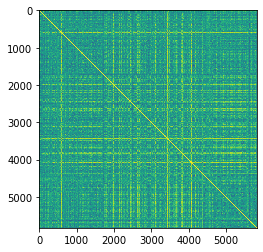

In [37]:
plt.imshow(subpeak_sim)

In [29]:
spec_std = SpectraRegion(sub_peaks, sub_masses, "subset_masses")

In [30]:
spec_std.spectra_similarity = subpeak_sim_norm

In [31]:
spec_std.segment(method="MEDIAN", number_of_regions=15)

2020-07-07 23:26:19,137  SpectraRegion  INFO: Calculating clusters
I0707 23:26:19.137463 140153823102784 segment.py:1061] Calculating clusters
2020-07-07 23:26:20,903  SpectraRegion  INFO: Calculating clusters done
I0707 23:26:20.903678 140153823102784 segment.py:1082] Calculating clusters done
2020-07-07 23:26:20,928  SpectraRegion  INFO: Calculating clusters saved
I0707 23:26:20.928632 140153823102784 segment.py:1100] Calculating clusters saved


array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int16)

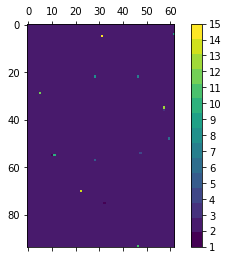

In [32]:
spec_std.plot_segments()

2020-07-07 23:32:46,135  SpectraRegion  INFO: Calculating clusters
I0707 23:32:46.135633 140153823102784 segment.py:1073] Calculating clusters
2020-07-07 23:32:46,169  SpectraRegion  INFO: UMAP reduction
I0707 23:32:46.169465 140153823102784 segment.py:986] UMAP reduction


Elem Matrix (5828, 719)


/usr/local/lib/python3.6/dist-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
2020-07-07 23:32:57,896  SpectraRegion  INFO: HDBSCAN reduction
I0707 23:32:57.896426 140153823102784 segment.py:994] HDBSCAN reduction
2020-07-07 23:32:58,047  SpectraRegion  INFO: Calculating clusters done
I0707 23:32:58.047563 140153823102784 segment.py:1094] Calculating clusters done
2020-07-07 23:32:58,056  SpectraRegion  INFO: Calculating clusters saved
I0707 23:32:58.056995 140153823102784 segment.py:1112] Calculating clusters saved


Dimred Shape (5828, 2)
Unassigned (0, 2)


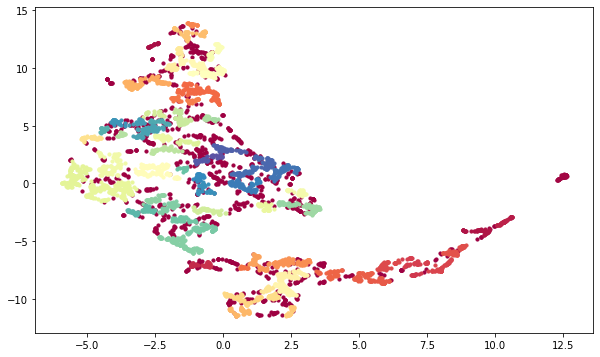

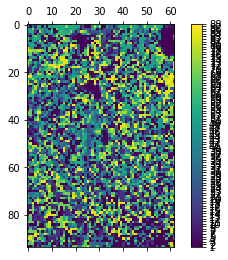

In [39]:
spec_std.segment(method="UMAP_DBSCAN",n_neighbors=5, min_samples=10, min_cluster_size=20)

mpl.rcParams['figure.figsize'] = (10,6)
spec_std.vis_umap(legend=False)
mpl.rcParams['figure.figsize'] = (6,4)

spec_std.plot_segments()

In [40]:
import seaborn as sns
import pandas as pd

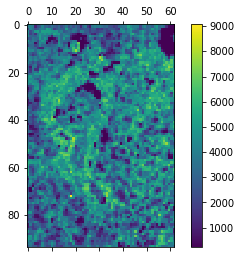

In [76]:
spec_std.plot_tic()

In [77]:
pdarr = pd.DataFrame(spec_std.elem_matrix / np.max(spec_std.elem_matrix))

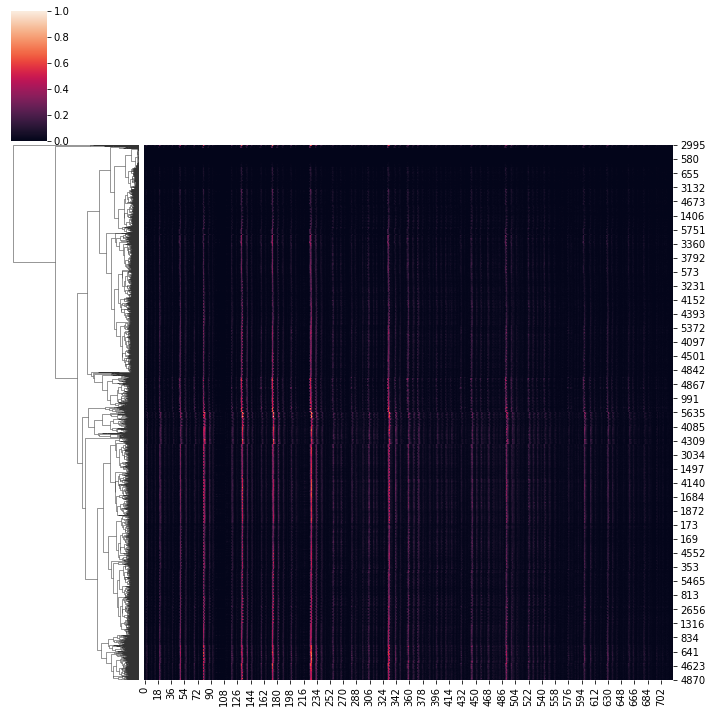

In [78]:
sns.clustermap(pdarr, col_cluster=False, row_cluster=True)

In [182]:
spec_subset = SpectraRegion(sub_peaks, sub_masses, "subset_masses")

In [186]:
spec_subset.calculate_similarity(mode="spectra_log")

2020-07-07 01:34:30,995  SpectraRegion  INFO: Creating C++ obj
I0707 01:34:30.995791 140209083385664 segment.py:811] Creating C++ obj
2020-07-07 01:34:30,998  SpectraRegion  INFO: 719 (94, 62, 719)
I0707 01:34:30.998478 140209083385664 segment.py:812] 719 (94, 62, 719)
2020-07-07 01:34:31,000  SpectraRegion  INFO: dimensions 719
I0707 01:34:31.000407 140209083385664 segment.py:822] dimensions 719
2020-07-07 01:34:31,002  SpectraRegion  INFO: input dimensions (94, 62, 719)
I0707 01:34:31.002395 140209083385664 segment.py:823] input dimensions (94, 62, 719)
2020-07-07 01:34:31,004  SpectraRegion  INFO: Switching to dot mode
I0707 01:34:31.004238 140209083385664 segment.py:826] Switching to dot mode
2020-07-07 01:34:31,048  SpectraRegion  INFO: Starting calc similarity c++
I0707 01:34:31.048956 140209083385664 segment.py:832] Starting calc similarity c++


719


2020-07-07 01:34:36,601  SpectraRegion  INFO: outclust dimensions (5828, 5828)
I0707 01:34:36.601086 140209083385664 segment.py:837] outclust dimensions (5828, 5828)
2020-07-07 01:34:36,604  SpectraRegion  INFO: Calculating spectra similarity
I0707 01:34:36.604266 140209083385664 segment.py:869] Calculating spectra similarity
2020-07-07 01:34:37,487  SpectraRegion  INFO: Calculating spectra similarity done
I0707 01:34:37.487196 140209083385664 segment.py:873] Calculating spectra similarity done


array([[1.        , 0.8886914 , 0.94358313, ..., 0.42837337, 0.5097377 ,
        0.37068847],
       [0.8886914 , 1.        , 0.98660064, ..., 0.67860025, 0.75591606,
        0.607904  ],
       [0.94358313, 0.98660064, 1.        , ..., 0.6182174 , 0.6974949 ,
        0.54653513],
       ...,
       [0.42837337, 0.67860025, 0.6182174 , ..., 1.        , 0.98987204,
        0.98647416],
       [0.5097377 , 0.75591606, 0.6974949 , ..., 0.98987204, 1.        ,
        0.9708533 ],
       [0.37068847, 0.607904  , 0.54653513, ..., 0.98647416, 0.9708533 ,
        1.        ]], dtype=float32)

In [194]:
spec_subset.segment(method="CENTROID", number_of_regions=15)

2020-07-07 01:35:53,735  SpectraRegion  INFO: Calculating clusters
I0707 01:35:53.735009 140209083385664 segment.py:1061] Calculating clusters
2020-07-07 01:35:56,930  SpectraRegion  INFO: Calculating clusters done
I0707 01:35:56.930651 140209083385664 segment.py:1082] Calculating clusters done
2020-07-07 01:35:56,949  SpectraRegion  INFO: Calculating clusters saved
I0707 01:35:56.949959 140209083385664 segment.py:1100] Calculating clusters saved


array([[ 9, 12,  9, ..., 13, 13, 11],
       [ 9, 12,  9, ..., 11,  7,  4],
       [12, 12, 12, ...,  4,  4,  4],
       ...,
       [11, 11, 13, ..., 13, 13, 11],
       [10, 11, 11, ..., 13, 13, 13],
       [10, 11, 11, ..., 13, 13, 11]], dtype=int16)

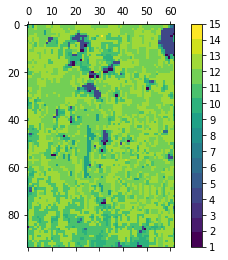

In [195]:
spec_subset.plot_segments()

In [191]:
spec_subset.filter_clusters(method='remove_singleton')
spec_subset.filter_clusters(method='merge_background')
spec_subset.filter_clusters(method='remove_islands')

2020-07-07 01:35:06,499  SpectraRegion  INFO: Assigning clusters to background: {1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20}
I0707 01:35:06.499232 140209083385664 segment.py:1189] Assigning clusters to background: {1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20}


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

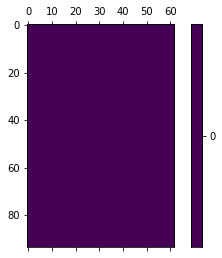

In [178]:
spec_subset.plot_segments()

In [33]:
spec_subset.segment(method="UMAP_DBSCAN", n_neighbors=5, min_samples=10, min_cluster_size=20)

NameError: name 'spec_subset' is not defined

Dimred Shape (5828, 2)
Unassigned (0, 2)


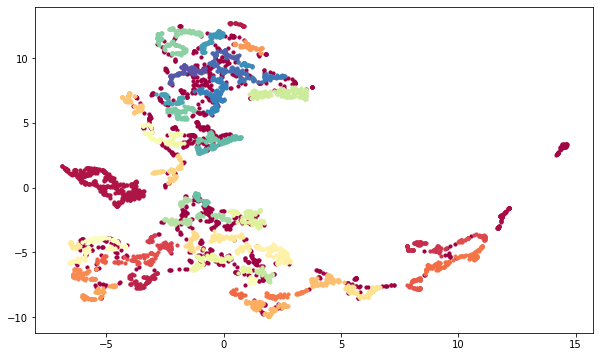

In [168]:
spec_subset.segment(method="UMAP_DBSCAN", n_neighbors=5, min_samples=10, min_cluster_size=20)

mpl.rcParams['figure.figsize'] = (10,6)
spec_subset.vis_umap(legend=False)
mpl.rcParams['figure.figsize'] = (6,4)

spec_subset.plot_segments()

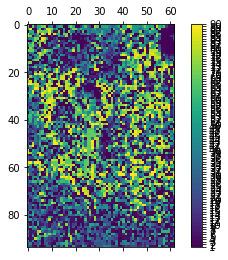

In [169]:
spec_subset.plot_segments()

In [57]:
spec_subset.filter_clusters(method='remove_singleton')
spec_subset.filter_clusters(method='merge_background')
spec_subset.filter_clusters(method='remove_islands')

2020-07-06 22:56:29,607  SpectraRegion  INFO: Assigning clusters to background: {1, 2, 3, 36, 5, 6, 7, 4, 10, 11, 13, 15, 16, 18, 25, 29}
I0706 22:56:29.607889 140209083385664 segment.py:1160] Assigning clusters to background: {1, 2, 3, 36, 5, 6, 7, 4, 10, 11, 13, 15, 16, 18, 25, 29}


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

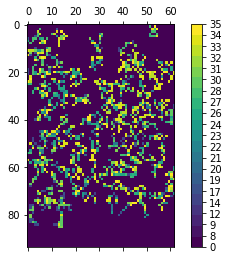

In [58]:
spec_subset.plot_segments()

In [ ]:
def calc_dot_sim( mat ):
    
    bar = progressbar.ProgressBar()
    
    elems = mat.shape[0]*mat.shape[1]
    
    result = np.zeros((elems, elems))
    mats = np.array(mat, copy=True)
    
    def normalized(a, axis=-1, order=2):
        l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
        l2[l2==0] = 1
        return a / np.expand_dims(l2, axis)
    
    print("Normalizing Matrix Start", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    mats = normalized(mat,2)
    print("Normalizing Matrix End", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
        
    print("Calculating cosine similarity Start", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    for i in bar(range(0, mats.shape[0])):
        for j in range(0, mats.shape[1]):
            idxI = i*mats.shape[1] + j
            
            for k in range(0, mats.shape[0]):
                for l in range(0, mat.shape[1]):
                    idxJ = k*mats.shape[1] + l
                    
                    if idxJ == idxI:
                        result[idxI, idxJ] = 1
                        continue
                    
                    if idxJ < idxJ:
                        continue
                        
                    cosSim = np.dot(mats[i,j,:], mats[k,j,:])
                    result[idxI, idxJ] = cosSim
                    result[idxJ, idxJ] = cosSim
                    
    print("Calculating cosine similarity End", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
                    
    return result
            
            

In [ ]:
npcos = calc_dot_sim( sh_array )

In [15]:
spec_sh.segment(method="WARD", number_of_regions=15)

NameError: name 'spec_sh' is not defined

In [ ]:
spec_sh.plot_segments()

In [ ]:
spec_sh.filter_clusters(method='remove_singleton')
#spec_sh.filter_clusters(method='merge_background')
#spec_sh.filter_clusters(method='remove_islands')

In [ ]:
spec_sh.plot_segments()

In [ ]:
plt.imshow(sh_array[:,:,100])

In [ ]:
plt.figure(figsize=(20, 6))
mzvals = range(0,len(refSpec))
plt.plot(mzvals, refSpec, label="30,1")

for idx in i2sp:
    plt.plot(mzvals, i2sp[idx], label="spec {} shifted".format(idx))


plt.legend()

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(imze.mzValues, spec.region_array[40,40])

In [ ]:
spec32, spec32Idx, origCoords = imze.get_pixel_spectrum(2, (3,2))

In [ ]:
spec32Idx, origCoords

In [ ]:
ridx = imze.get_region_index_array(2)

In [ ]:
ridx[0:5,0:5]

In [ ]:
[x for x in imze.parser.coordinates if x[0] == 693 and x[1] == 317]

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(imze.mzValues, spec32)

In [ ]:
spec.calculate_similarity(mode="spectra_log_dist")

In [ ]:
import progressbar

bar = progressbar.Bar()

for x in bar(range(0,10)):
    sleep(1)